# Spatial dispersion, aka nonlocality #

The optical response of metals and doped semiconductors is dictated by the electron gas they contain. The earliest description of such a response has been proposed by Drude. The Drude model is very accurate, to the point that only in 2012 experiments have shown that it is necessary to go beyond the Drude model to describe the response of metals more accurately. Well, for metals it is maybe not really necessary to do so. But for n-doped semiconductors, this might be unavoidable. The purpose of this notebook is to show how the optical response, in the infra-red, of a simple semi-conductor slab has to be modelized using a hydrodynamic model for the electron gas.

We combine here several things we've done in the past with the capabilities of PyMoosh:
- __[The hydrodynamic model]{https://arxiv.org/pdf/1211.5504}__ with the right boundary conditions
- __[A scattering matrix formalism]{https://arxiv.org/pdf/1410.4996}__ for nonlocal materials
- __[Optimization capabilities of Moosh]{https://opg.optica.org/directpdfaccess/39ba1587-138f-4ab8-a9ce0d85412b4f02_546050/josab-41-2-a126.pdf}__ through the use of Quasi-Opposite Differential Evolution 

With all of that, we manage to retrieve the parameters for the model that best fit the actual experimental data !

## Basics: reflectance spectra with nonlocal materials ##

First we import numpy :heart: and our beloved PyMoosh. Be aware that this imports only the basic functions. We use also matplotlib and csv for the experimental data.


In [6]:
import numpy as np
import PyMoosh as PM
import matplotlib.pyplot as plt
import csv

Now, we import the nonlocal part of PyMoosh (brute force version)

In [7]:
from PyMoosh.non_local import *

We load the experimental data (thank you Thierry Taliercio !) so that it is available to all the following functions.

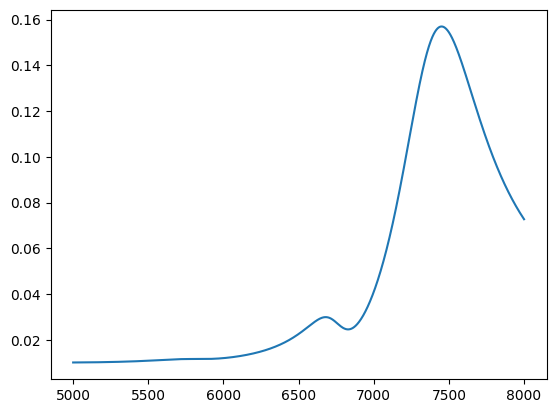

In [8]:
wavelength_list = np.linspace(5000, 8000, 3001)
with open('nlplot.data', newline='') as csvfile:
    expdata = list(csv.reader(csvfile))[0]
expdata = [float(p.strip()) for p in expdata]
expdata = np.array(expdata)
refplot, = plt.plot(wavelength_list, expdata, label="Reference")

You can see two (almost three, there is a small one around 5750 nm) resonances here. The main one can be partially understood with the Drude model and a "rigid" electron gas. The other one not at all. In order to use a non-local material, we have first to declare a function that, when given the wavelength in nm, provides the required model parameters:
- $\eta^2$, the complex version of $\beta^2$ where $\beta$ is the main nonlocal parameter. Said otherwise, the real part of $\eta^2$ is $\beta^2$.
- $\chi_b$ the susceptibility of the background (the response of the bound electrons typically)
- $\chi_f$ the susceptibility of the free electrons (hence the "f") described by a Drude model essentially
- $\omega_p$ the plasma frequency

While $\eta^2$ is complex here, it does not change with the frequency. For now. Using $\chi_b$ and $\chi_f$ it is possible to compute the permittivity of the material, so that, if you are familiar with PyMoosh, you understand that this function replaces the function defining a material that provides the permittivity as a function of the wavelength.

In [9]:
def dopedsc_basic(wavelength):
    chi_b = 11.6644913
    w_p = 8.9e+14
    gamma = 3.53201120e+12
    beta2 = 1.92864068e+30
    w = 2*np.pi*299792458*1e9 / wavelength
    # We put a negative imaginary part for the losses that are intrinsic
    # to the electron gas. Nothing dispersive here.
    eta2 = beta2 - 1.0j*2.2881657413884294e+29
    chi_f = - w_p**2/(w * (w + 1j * gamma))
    return eta2, chi_b, chi_f, w_p

Now we define the structure using specific nonlocal functions and classes. We declare a nonlocal material using `NLMaterial` the nonlocal class for nonlocal materials and then declare a structure just like with PyMoosh except it is a structure containing a nonlocal material so that it is called `NLStructure`. The structure is a simple 105 nm thick doped semiconductor surrounded by high index materials.

In [11]:
nSC = NLMaterial(dopedsc_basic)
# The materials:
materials = [15.6816, nSC, 14.2129]
# And how we stack them.
stack = [0, 1, 2]
# Their thickness. For the superstrate and the substrate, thickness makes
# no sense so let's put it to 0.
thickness = [0, 105, 0]
theta = np.pi * 37 / 180
pol = 1.0
simple_nl = NLStructure(materials,stack,thickness)


List of materials:
Simple, non dispersive: epsilon= (15.6816+0j)
Object: NLMaterial
Simple, non dispersive: epsilon= (14.2129+0j)


Now we plot both reference and the result of the model. And to convince you, we add the prediction of the Drude model with the same plasma frequency and losses.

List of materials:
Simple, non dispersive: epsilon= (15.6816+0j)
Custom dispersive material. Epsilon= scdrude (wavelength in nm)
Simple, non dispersive: epsilon= (14.2129+0j)


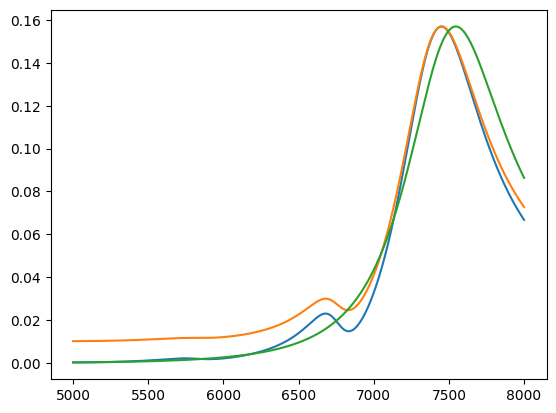

In [25]:
R_simple = []
for wl in wavelength_list:
    _,_,R,_ = NLcoefficient(simple_nl,wl,theta,pol)
    R_simple.append(R)
R_simple=np.array(R_simple)
R_simple = R_simple/max(R_simple)*max(expdata)
simpleplot, = plt.plot(wavelength_list,R_simple,label="Simple NL")

refplot, = plt.plot(wavelength_list, expdata, label="Reference")

# In PyMoosh
# Drude model
def scdrude(wavelength):
    chi_b = 11.6644913
    w_p = 8.9e+14
    gamma = 3.53201120e+12
    w = 2*np.pi*299792458*1e9 / wavelength
    chi_f = - w_p**2/(w * (w + 1j * gamma))
    return 1+chi_f+chi_b

drude = PM.Structure([15.6816, scdrude, 14.2129],stack,thickness)
R_drude = []
for wl in wavelength_list:
    _,_,R,_ = PM.coefficient(simple_nl,wl,theta,pol)
    R_drude.append(R)
R_drude=np.array(R_drude)
R_drude = R_drude/max(R_drude)*max(expdata)
drudeplot, = plt.plot(wavelength_list,R_drude,label="Simple NL")

As you can see, with the local version the main resonance (Ferrel resonance) is shifted and the higher order resonances do not show up. This is because all these resonances are cavity resonances for the (bulk) plasmon propagating inside the semiconductor slab. Obivously the experimental data suggest the Drude model is not sufficient...

## Advanced: advanced fits of experimental data ##

### Dispersion in the complex part of the nonlocal parameter ###

Now, we use another model with a dispersive imaginary part for $\eta^2$. This corresponds, formally, to implementing the GNOR model even though the physical grounds of the model are shaky. The model is nonetheless completely right on the form of the dispersion for the imaginary part.

Here we define the model but the parameters of the model (that allow to compute the parameters of the nonlocal material) have to be provided also. This will allow us to change them dynamically and to make better fits !

And we declare the material as above by providing a list with the name of the function and the values of the supplementary parameters beyond the wavelength. 

List of materials:
Simple, non dispersive: epsilon= (15.6816+0j)
Object: NLMaterial
Simple, non dispersive: epsilon= (14.2129+0j)


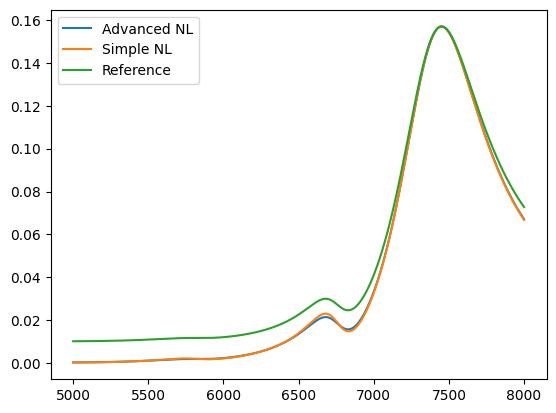

In [29]:
def sc_dispersive(wavelength, chi_b, w_p, gamma, beta_0, tau):
    w = 2*np.pi*299792458*1e9 / wavelength
    eta2 = beta_0**2 - 1.0j * w * tau
    chi_f = - w_p**2/(w * (w + 1j * gamma))

    return eta2, chi_b, chi_f, w_p

nSC_2nd = NLMaterial([sc_dispersive,11.6644913,8.9e+14,3.53201120e+12,np.sqrt(1.92864068e+30),9.718e14])

advanced_nl = NLStructure([15.6816, nSC_2nd, 14.2129],stack,thickness)
R_advanced = []
for wl in wavelength_list:
    _,_,R,_ = NLcoefficient(advanced_nl,wl,theta,pol)
    R_advanced.append(R)
R_advanced=np.array(R_advanced)
R_advanced = R_advanced/max(R_advanced)*max(expdata)
advancedplot, = plt.plot(wavelength_list,R_advanced,label="Advanced NL")
simpleplot, = plt.plot(wavelength_list,R_simple,label="Simple NL")
refplot, = plt.plot(wavelength_list, expdata, label="Reference")


plt.legend()
plt.show()


There is a tiny difference here. The first resonance is perfectly the same, because the value for the imaginary part is taken equal for both model here. But the nondispersive model predicts more visibile resonances (very slightly) while the dispersive one does not. Our data may be sufficient to claim that a dispersive behavior of the imaginary part is necessary. 

### Cost function ###

The cost function that is usually used is in general the norm of the difference between the model and the data. Here we don't do exactly that because 
- The model is totally expected not the fit the experimental data perfectly
- The important part is having the resonances at the right place with the right profile

What we do is also take the difference between the increments from one wavelength to the other. We also take into account the fact that these are brute experimental data, so that the scale and the base level are arbitratry. It looks like this:

In [31]:
def cost_function(X):
    chi_b, w_p, gamma, beta_0, tau, base, scale = X
    sc_nl = NLMaterial([sc_dispersive, chi_b, w_p, gamma, beta_0, tau])
    nb_lam = 50
    materials = [15.6816, sc_nl, 14.2129]
    stack = [0, 1, 2]
    thickness = [0, 105, 0]
    thing = NLStructure(materials,stack,thickness,verbose=False)
    new_wl = np.linspace(5000,8000,nb_lam)
    R=np.zeros(nb_lam)
    for k in range(nb_lam):
        _,_,R[k],_ = NLcoefficient(thing,new_wl[k],np.pi * 37 / 180,1.0)
    R = R*scale + base
    obj  = np.interp(new_wl, wavelength_list, expdata)
    cost = np.mean(np.abs(R - obj))+20*np.mean(np.abs(np.diff(R)-np.diff(obj)))
    return cost/nb_lam


### Optimization ###

Now we just launch an optimization trying to minimize this cost function using QODE. The optimization domain is chosen given the information we have on the material and the values of the parameters (they can be roughly determined by hand, the role of the optimization is to find automatically the very best parameters). 

In [34]:
X_min = np.array([11.4, 1e14, 1e12, 1e14, 6e14, 0, 0.01])
X_max = np.array([11.8, 1e15, 1e13, 1.5e15, 1.2e15, 0.2, 2])

best , convergence = PM.QODE(cost_function,2000,X_min,X_max,progression=10)


Progression : 7.61%. Current cost : 0.002461
Progression : 10.15%. Current cost : 0.002461
Progression : 20.3%. Current cost : 0.001083
Progression : 20.3%. Current cost : 0.001083
Progression : 30.46%. Current cost : 0.00076
Progression : 38.07%. Current cost : 0.000687
Progression : 40.61%. Current cost : 0.000687
Progression : 43.15%. Current cost : 0.000387
Progression : 48.22%. Current cost : 0.000266
Progression : 50.76%. Current cost : 0.000266
Progression : 60.91%. Current cost : 0.000211
Progression : 71.07%. Current cost : 0.000196
Progression : 81.22%. Current cost : 0.0001
Progression : 86.29%. Current cost : 9.9e-05
Progression : 91.37%. Current cost : 9.9e-05


Now we will visualize the result (which is stored in `best`). 

List of materials:
Simple, non dispersive: epsilon= (15.6816+0j)
Object: NLMaterial
Simple, non dispersive: epsilon= (14.2129+0j)


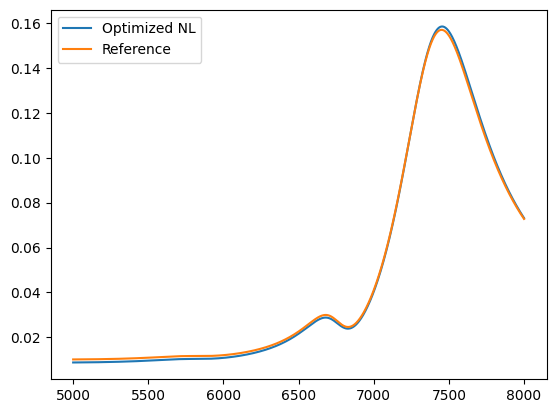

In [35]:
chi_b, w_p, gamma, beta_0, tau, base, scale = best

nSC_2nd = NLMaterial([sc_dispersive,chi_b, w_p, gamma, beta_0, tau])
optimized_nl = NLStructure([15.6816, nSC_2nd, 14.2129],stack,thickness)
R_optim = []
for wl in wavelength_list:
    _,_,R,_ = NLcoefficient(optimized_nl,wl,theta,pol)
    R_optim.append(R)
R_optim=np.array(R_optim)
# Rescaling !
R_optim = R_optim*scale+base
optimizedplot, = plt.plot(wavelength_list,R_optim,label="Optimized NL")
refplot, = plt.plot(wavelength_list, expdata, label="Reference")

plt.legend()
plt.show()


**Now we can claim victory !**